In [14]:
from time import time
import gpax
import numpyro
import matplotlib.pyplot as plt

In [ ]:


def schwefel_1d(x):

    return 418.9829  - x * np.sin(np.sqrt(np.abs(x)))

def schwefel_nd(args):
    output = 0
    
    for dim in range(args):
        output += schwefel_1d(args[dim])

def add_gaussian_noise(signal, noise_level):

    return signal + np.random.normal(0, noise_level, 1)[0]

def schwefel_1d_with_noise(x, noise_level = 0.01):
    # Calculate the Schwefel function value

    schwefel_value = schwefel_1d(x)

    # Add Gaussian noise to the Schwefel function value

    noisy_schwefel_value = add_gaussian_noise(schwefel_value, noise_level)

    return noisy_schwefel_value

def schwefel_nd_with_noise(args, noise_level = 0.01):
    # Calculate the Schwefel function value

    schwefel_value = schwefel_nd(args)

    # Add Gaussian noise to the Schwefel function value

    noisy_schwefel_value = add_gaussian_noise(schwefel_value, noise_level)

    return noisy_schwefel_value




In [ ]:

def create_data(seed, n_init, noise_level):

    np.random.seed(seed)
    X_bounds = np.array([-500,  500])
    X = np.random.uniform(X_bounds[0], X_bounds[1], size=( n_init,))
    X = np.append(X, X_bounds)
    X = np.sort(X)
    y = schwefel_1d_with_noise(X, noise_level = noise_level)

    X_unmeasured = np.linspace(X_bounds[0], X_bounds[1], 200)
    ground_truth = schwefel_1d_with_noise(X_unmeasured, noise_level = 0)
    
    return X, y, X_unmeasured, ground_truth


In [16]:
X, y, X_unmeasured, ground_truth = create_data(5, 15, 0.01)

In [17]:
# set variable names for gpax:

X_test = X_unmeasured


In [18]:
import gpax
# Get random number generator keys (see JAX documentation for why it is neccessary)
rng_key, rng_key_predict = gpax.utils.get_keys()

# Initialize model
gp_model = gpax.ExactGP(1, kernel='Matern')

# Run HMC to obtain posterior samples
gp_model.fit(rng_key, X, y, num_chains=1)

# Get GP prediction
posterior_mean, f_samples = gp_model.predict(rng_key_predict, X_test, n=200)

sample: 100%|█| 4000/4000 [00:02<00:00, 1438.98it/s, 3 steps o



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]     60.16     18.79     64.62     43.15     82.82     28.27      1.01
    k_scale  72369.17  15777.58  70201.93  53413.12  99248.16     53.36      1.03
      noise      1.62      1.59      1.15      0.09      3.63     70.02      1.01



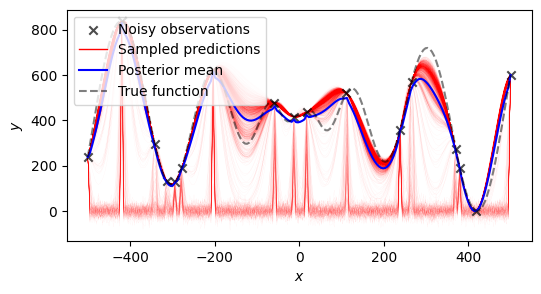

In [19]:
# plot results

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X, y, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
for y1 in f_samples:
    ax.plot(X_test, y1.mean(0), lw=.1, zorder=0, c='r', alpha=.1)
l, = ax.plot(X_test, f_samples[0].mean(0), lw=1, c='r', alpha=1, label="Sampled predictions")
ax.plot(X_test, posterior_mean, lw=1.5, zorder=1, c='b', label='Posterior mean')
ax.plot(X_test, ground_truth, c='k', linestyle='--', label='True function', alpha=0.5)
ax.legend(loc='upper left')
l.set_alpha(0)